# A TUTORIAL ON BAYESIAN HIERARCHICAL REGRESSION MODELS USING STAN

by Sebastian T. Glavind, August, 2020

# Introduction

In this tutorial, we will consider how to define, train, and predict with a Bayesian hierarchical model using Stan. The interested reader is referred to the prominent textbook of Gelman et al. (2013) for an introduction to Bayesian hierarchical models.

We will consider the modeling conducted in Glavind et al. (2020), thus reflecting the crack propagation of four (normalized) fatigue experiments on tubular K-joints. The data was originally published in Stannard et. al. (1988) and the parametric model is based on work performed by Tychsen and co-works, see Tychsen (2017).

Following Glavind et al. (2020), the normalized crack growth ($a/a_c$) in a fatigue sensitive detail is assumed to follow the parametric model:

$$ f(x) = (1+\gamma)x^{\beta} - \gamma, $$
where $x$ is normalized fatigue cycles ($N/N_c$), $\beta$ is the growth rate of the power law relationship, and $\gamma \geq 0$ is a parameter accounting for crack initiation, see Glavind et al. (2020) for further details.

Now, if we further assume that the $\beta$'s and $\sigma$'s of $d$ experiments can be similar, and that the similarity can be inferred based on data, i.e. it is assumed that the $\beta$'s and $\sigma$'s have a common population distribution, we may utilize a hierarchical model structure. In this regard, the normalized crack depths $y_{d}$ are assumed to follow a normal distribution, with covariates $x_d$, and standard deviation $\sigma_d$, which are assumed to be half-cauchy distributed with hyper-parameters $\mu_s$ and $\sigma_s$. Moreover, the exponents $\beta_d$ are assumed to follow a log-normal distribution with hyper-parameters $\mu_b$ and $\sigma_b$, see Glavind et al.(2020) for further details.

***
A. Gelman, J. B. Carlin, H. S. Stern, D. B. Dunson, A. Vehtari, and D. B. Rubin, Bayesian data analysis. CRC press, 2013.

Sebastian T. Glavind, Henning Brüske and Michael H. Faber, “On normalized fatigue crack growth modeling”, in proceedings of the ASME 2020 39th International Conference on Ocean, Offshore and Arctic Engineering (OMAE2020), OMAE2020-18613, 2020.

D. Stannard, P. Forsyth, and M. Lalani, “New Data On Crack Growth Characteristics Of Fatigue-Loaded Complex Tubular Joints,” in Offshore Technology Conference, vol. 1988-May. Houston, TX, USA: Offshore Technology Conference, apr 1988, pp. 439–447. http://www.onepetro.org/doi/10.4043/5664-MS

J. Tychsen, “Development of normalized stochastic fatigue crack growth model,” Maersk Oil, Tech. Rep., 2017.
***

# Prelude

In [1]:
import math
import numpy as np
import scipy.stats as ss
import pandas as pd
import pystan
import pickle
import matplotlib
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Data

Data used in Glavind et al. (2020); the training data $\mathcal{D}=\{ x[n], y[n] \}_{n=1}^N$ for the hierarchical model over fatigue experiments consists of noisy observations of the normalized fatigue crack depth $y$, as a function of the normalized fatigue load cycles $x$.

In [2]:
# Normalized no. of cycles - load cycles / critical load cycles (N/Nc)
X = list([np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]), 
         np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]), 
         np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]), 
         np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])])
# Normalized crack depth - crack depth / critical crack depth (a/ac)
Y = list([np.array([0.01,  0.01,  0.072, 0.17,  0.34,  0.545, 0.68,  0.77,  0.873]),
         np.array([0.01,  0.01,  0.013, 0.063, 0.135, 0.19,  0.248, 0.315, 0.423]),
         np.array([0.01,  0.01,  0.01,  0.01,  0.036, 0.09,  0.18,  0.43,  0.79 ]),
         np.array([0.01,  0.01,  0.01,  0.01,  0.013, 0.036, 0.072, 0.11,  0.216])])
# Nominal thickness for each experiment
Tnom = np.array([16, 16, 16, 16])
# Critical load cycles for each experiment
Nc = np.array([2650000.0, 1080000.0, 1290000.0, 728000.0])
# Stress range for each experiment
ds = np.array([91.0, 100.0, 127.0, 104.0]) # [N/mm2]

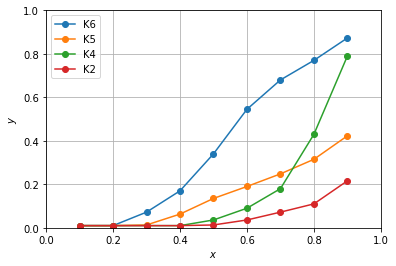

In [3]:
plt.figure()
for i in range(len(X)): 
    plt.plot(X[i], Y[i],'-o')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.ylim([0, 1]);
plt.xlim([0, 1]);
plt.legend(['K6', 'K5', 'K4', 'K2'])
plt.grid()

# Hierarchical modeling in Stan

## Prepare data for Stan

In [4]:
ind = np.repeat([0,1,2,3], [len(X[0]), len(X[1]), len(X[2]), len(X[3])], axis=0)
ind = np.ndarray.tolist(ind+1) # stan starts at 1
x = np.concatenate(X, axis=0)
x = np.ndarray.tolist(x)
y = np.concatenate(Y, axis=0)
y = np.ndarray.tolist(y)
N = len(x)
J = 4

In [5]:
exp_dat = {'J': J,
           'N': len(x),
           'x': x,
           'y': y,
           'ind': ind}

## Hierarchical model formulation

In [6]:
exp_code = """
data {
    int<lower=1> J; // number of experimental series
    int<lower=1> N; // number of data points (series times within series data points)
    vector[N] x; // covariate vector
    vector[N] y; // response vector
    int<lower=1,upper=J> ind[N]; //vector of group indeces
}
parameters {
    real mu_b;
    real<lower=0> sigma_b;
    real mu_s;
    real<lower=0> sigma_s;
    vector<lower=0>[J] beta;
    vector<lower=0>[J] sigma;
    vector<lower=0>[J] gamma;
}
model {
    gamma ~ cauchy(0, 10);
    beta ~ lognormal(mu_b, sigma_b);
    sigma ~ cauchy(mu_s, sigma_s);
    for(n in 1:N)
        y[n] ~ normal((1 + gamma[ind[n]])*(x[n] ^ beta[ind[n]]) - gamma[ind[n]], sigma[ind[n]]); // response
}
generated quantities {
    vector[N] log_lik; //log-likelihood of the data points
    for(n in 1:N)    
        log_lik[n] = normal_log(y[n], (1 + gamma[ind[n]])*(x[n] ^ beta[ind[n]]) - gamma[ind[n]], sigma[ind[n]]);
}
"""

## Compile model

To compile please uncomment the cell below - the model is compiled and saved, so we do not need to compile every time we assess the notebook.

In [7]:
# sm = pystan.StanModel(model_code=exp_code)
# # save model
# with open('HierModel_OMAE2020_model.pkl', 'wb') as f:
#     pickle.dump(sm, f)

## Sampling from the model

In [8]:
sm = pickle.load(open('HierModel_OMAE2020_model.pkl', 'rb'))
fit = sm.sampling(data=exp_dat, iter=2000, chains=4, seed=42)
# control = {}; control['adapt_delta'] = 0.9; control['max_treedepth'] = 20
# fit = sm.sampling(data=exp_dat, iter=2000, chains=4, seed=42, control=control); 
print(fit)

Inference for Stan model: anon_model_d4ad102d411ecc38eacdf715becd625d.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu_b           1.3    0.06   1.39   -1.6   0.87   1.35   1.82   4.01    605    1.0
sigma_b       2.09    0.08   2.23    0.6   1.02   1.46   2.25   7.82    722   1.01
mu_s          0.07  6.6e-4   0.02   0.03   0.06   0.07   0.08   0.12   1406    1.0
sigma_s       0.03  1.4e-3   0.05 7.6e-4 6.8e-3   0.02   0.03   0.14   1222    1.0
beta[1]        1.2  4.8e-3   0.18   0.83   1.09   1.21   1.31   1.56   1424    1.0
beta[2]       4.73    0.02   0.94   3.11   4.12   4.67   5.22   6.81   2277    1.0
beta[3]       3.69    0.01   0.41   2.89   3.42   3.68   3.93   4.51   1521    1.0
beta[4]      13.17     0.3    5.6   8.98  11.32  12.66  14.11  19.11    359   1.01
sigma[1]      0.07  4.6e-4   0.02   0.04   0.06   0.07   0.08   

The $\text{Rhat} \approx 1$ values indicate a reliable fit (convergence).

## Extract the samples

In [9]:
hie_samp = fit.extract(permuted=True)
beta_samp = hie_samp['beta']
sigma_samp = hie_samp['sigma']
gamma_samp = hie_samp['gamma']
mu0_samp = hie_samp['mu_b']
sigma0_samp = hie_samp['sigma_b']
mu1_samp = hie_samp['mu_s']
sigma1_samp = hie_samp['sigma_s']
log_lik = hie_samp['log_lik']
fit_summary = fit.summary()

## Model assessment using leave-one-out cross-validation (LOO-CV)

For this assessment, we will use an efficient implementation of Pareto smoothed importance sampling (PSIS) leave-one-out (LOO) cross-validation (CV), which is found at https://github.com/avehtari/PSIS for both Python, R and Matlab. LOO is a method for estimating pointwise out-of-sample prediction accuracy from a fitted Bayesian
model using the log-likelihood evaluated at the posterior simulations of the parameter values. Exact CV requires re-fitting the model with different training sets, but approximate LOO-CV can be computed efficiently using importance sampling, where a Pareto distribution is fitted to the upper tail of the importance weights distribution to reduce the noise in the estimate, as importance weights can grow large or even infinite, see Vehtari et al. (2017) or Gelman et al. (2013) for further details.


***
A. Vehtari, A. Gelman, and J. Gabry. Practical Bayesian model evaluation using leave-one-out cross-validation and WAIC. Statistics and computing 27.5 (2017): 1413-1432.

A. Gelman, J. B. Carlin, H. S. Stern, D. B. Dunson, A. Vehtari, and D. B. Rubin, Bayesian data analysis. CRC press, 2013.
***


### LOO expected log pointwise predictive density

In [10]:
import psis
# Compute PSIS-LOO
# 'log_lik' is the incremental contributions to the log-likelihood 
loo, loos, ks = psis.psisloo(log_lik); 

# Compute the corresponding, effective number of parameters in the model
lppd = np.sum(np.log(np.mean(np.exp(hie_samp['log_lik']), axis=0))) # Gelman et al. (2013), eq. 7.5
peff = lppd - loo; # Gelman et al. (2013), eq. 7.15

print('LOO expected log pointwise predictive density: ', np.round(loo,3)) 
print('Effective number of parameters:', np.round(peff,3), '(between 1 and all model parameters, i.e. 16)')

LOO expected log pointwise predictive density:  38.631
Effective number of parameters: 11.332 (between 1 and all model parameters, i.e. 16)


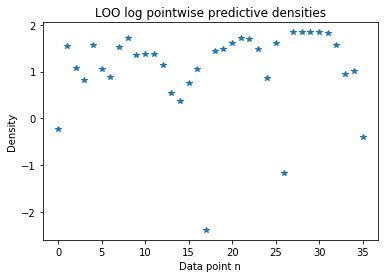

In [11]:
plt.plot(loos, '*')
plt.title(r'LOO log pointwise predictive densities')
plt.xlabel(r'Data point n');
plt.ylabel(r'Density');

### Shape parameter $k$ of the Pareto distributions

These should generally be smaller than $0.5-0.7$ for the approximation to be reliable, see Vehtari et al. (2017) for further details.

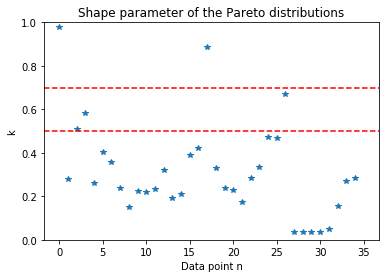

In [12]:
plt.plot(ks, '*')
plt.axhline(0.5, linestyle ='dashed', color='red')
plt.axhline(0.7, color='red', linestyle='dashed')
plt.title(r'Shape parameter of the Pareto distributions');
plt.xlabel(r'Data point n');
plt.ylabel(r'k');
plt.ylim(0,1);

## Plotting Stan samples

### $\beta$ samples

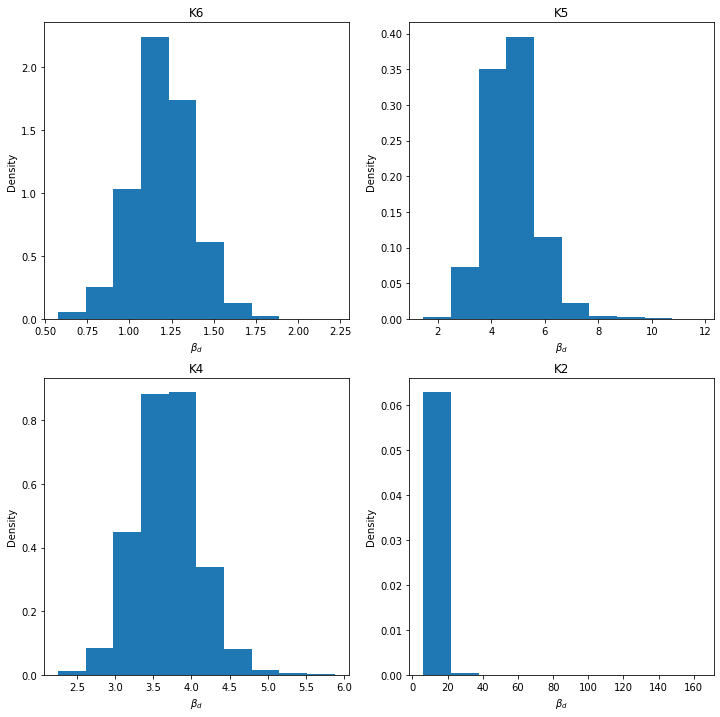

In [13]:
# Plotting function
def ax_plt_params(ax, alp_v, title, xlab):
    ax.hist(alp_v, density=True)
    ax.set_title(title)
    ax.set_xlabel(xlab)
    ax.set_ylabel('Density')

# Initialize plots
fa, a_ax = plt.subplots(2,2, figsize=(12, 12))
# Plot tasks
ax_plt_params(a_ax[0,0], beta_samp[:,0], 'K6', r'$\beta_d$')
ax_plt_params(a_ax[0,1], beta_samp[:,1], 'K5', r'$\beta_d$')
ax_plt_params(a_ax[1,0], beta_samp[:,2], 'K4', r'$\beta_d$')
ax_plt_params(a_ax[1,1], beta_samp[:,3], 'K2', r'$\beta_d$')

### $\gamma$ samples

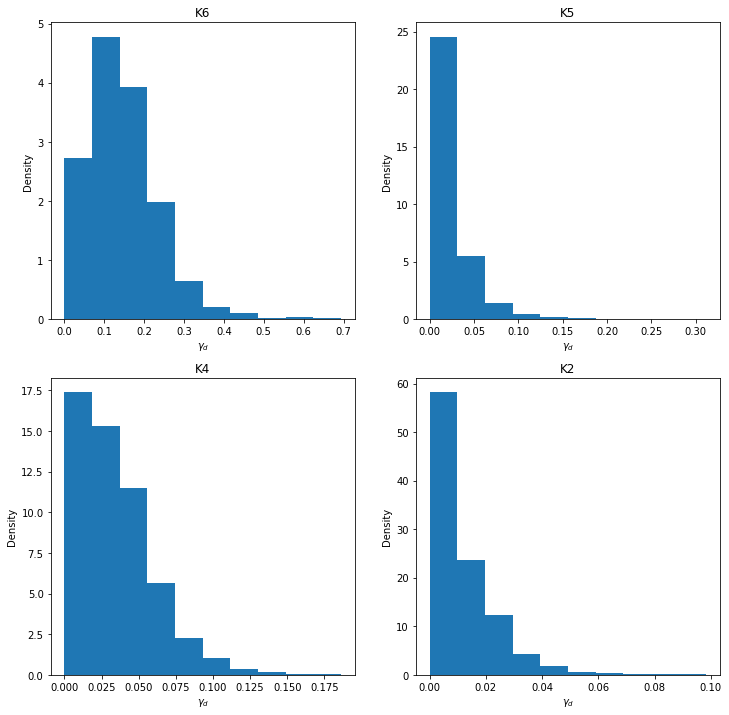

In [14]:
# Initialize plots
fa, a_ax = plt.subplots(2,2, figsize=(12, 12))
# Plot tasks
ax_plt_params(a_ax[0,0], gamma_samp[:,0], 'K6', r'$\gamma_d$')
ax_plt_params(a_ax[0,1], gamma_samp[:,1], 'K5', r'$\gamma_d$')
ax_plt_params(a_ax[1,0], gamma_samp[:,2], 'K4', r'$\gamma_d$')
ax_plt_params(a_ax[1,1], gamma_samp[:,3], 'K2', r'$\gamma_d$')

### $\sigma$ samples

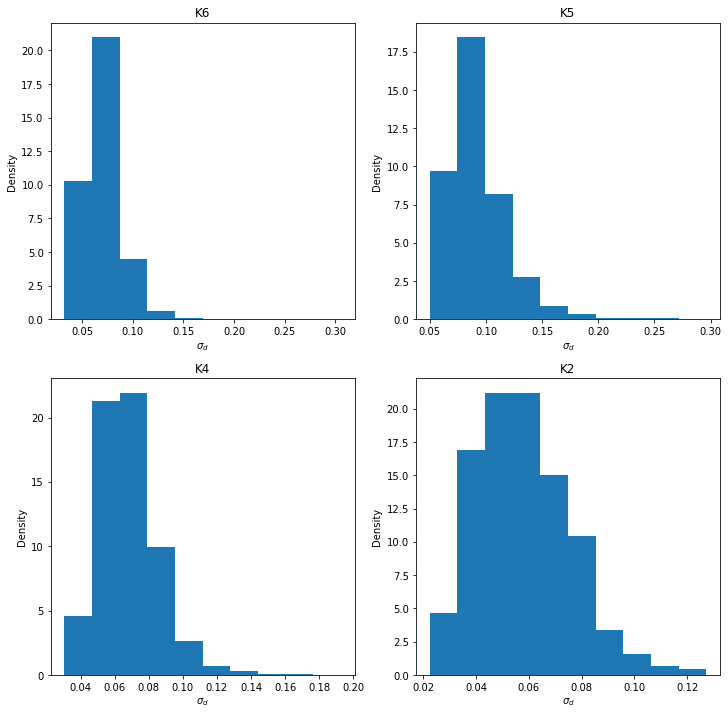

In [15]:
# Initialize plots
fs, s_ax = plt.subplots(2,2, figsize=(12, 12))
# Plot tasks
ax_plt_params(s_ax[0,0], sigma_samp[:,0], 'K6', r'$\sigma_d$')
ax_plt_params(s_ax[0,1], sigma_samp[:,1], 'K5', r'$\sigma_d$')
ax_plt_params(s_ax[1,0], sigma_samp[:,2], 'K4', r'$\sigma_d$')
ax_plt_params(s_ax[1,1], sigma_samp[:,3], 'K2', r'$\sigma_d$')

### $\mu_b$  and $\sigma_b$ samples

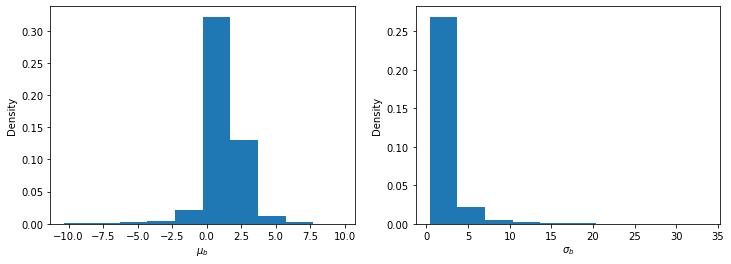

In [16]:
# Plotting function
def ax_plt_hyp(ax, hyp_v, lab_ax):
    ax.hist(hyp_v, density=True)
    ax.set_xlabel(lab_ax)
    ax.set_ylabel('Density')

# Initialize plots
fa0, a0_ax = plt.subplots(1,2, figsize=(12, 4))
# Plot tasks
ax_plt_hyp(a0_ax[0], mu0_samp, r'$\mu_b$')
ax_plt_hyp(a0_ax[1], sigma0_samp, r'$\sigma_b$')

### $\mu_s$  and $\sigma_s$ samples

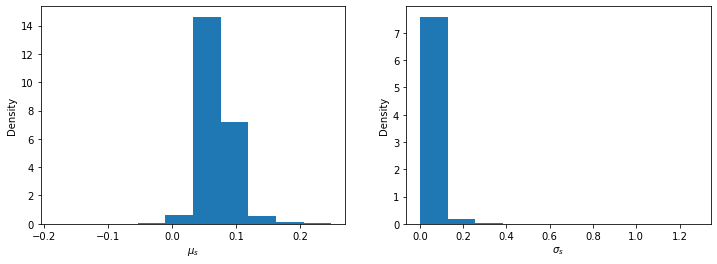

In [17]:
# Initialize plots
fa1, a1_ax = plt.subplots(1,2, figsize=(12, 4))
# Plot tasks
ax_plt_hyp(a1_ax[0], mu1_samp, r'$\mu_s$')
ax_plt_hyp(a1_ax[1], sigma1_samp, r'$\sigma_s$')

## Ploting resulting models

### Compute sample statistics for the models

In [18]:
# Function for calculating function statistics
def my_f_y_stats(x_vec, beta_vec, sigma_vec, gamma_vec):
    f_stats = np.zeros((len(x_vec),3))
    y_stats = np.zeros((len(x_vec),3))
    noise_y = np.random.normal(np.zeros(sigma_vec.shape), sigma_vec)
    for i in range(len(x_vec)):
        f_samp_i = (1 + gamma_vec)*x_vec[i]**(beta_vec) - gamma_vec
        y_samp_i = f_samp_i + noise_y
        # f-stats
        f_samp_i_m = np.mean(f_samp_i)
        f_samp_i_q = np.quantile(f_samp_i, [0.025, 0.975])
        f_stats[i,:] = np.concatenate(([f_samp_i_m],f_samp_i_q), axis=0)
        # y-stats
        y_samp_i_m = np.mean(y_samp_i)
        y_samp_i_q = np.quantile(y_samp_i, [0.025, 0.975])
        y_stats[i,:] = np.concatenate(([y_samp_i_m],y_samp_i_q), axis=0)
    return f_stats, y_stats

# Sample statistics for models
F_stats = []
Y_stats = []
np.random.seed(123)
x_ax = np.arange(0, 1.01, 0.01)
for i in range(beta_samp.shape[1]):
    f_stats, y_stats = my_f_y_stats(x_ax, beta_samp[:,i], sigma_samp[:,i], gamma_samp[:,i])
    F_stats.append(f_stats)
    Y_stats.append(y_stats)

###  Plot of sample statistics for the models 

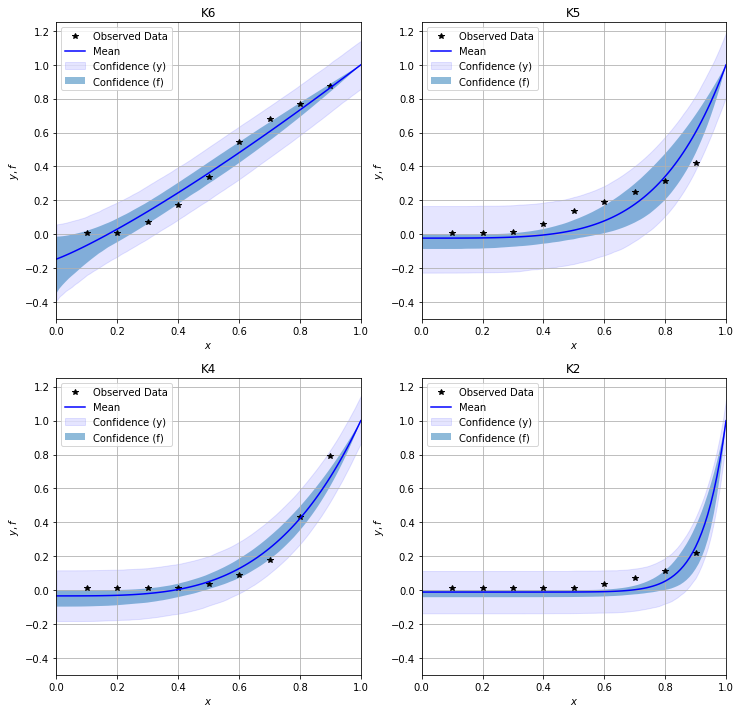

In [19]:
# Plotting function
def ax_plt_models(ax, train_y, train_x, test_x, rand_var_y, rand_var_f, title):
    # Plot training data as black stars
    ax.plot(train_x, train_y, 'k*')
    # Predictive mean as blue line
    ax.plot(test_x, rand_var_f[:,0], color='b')
    # Shade in confidence 
    ax.fill_between(test_x, rand_var_y[:,1], rand_var_y[:,2], alpha=0.1, color='blue')
    ax.fill_between(test_x, rand_var_f[:,1], rand_var_f[:,2], alpha=0.5)
    ax.set_ylim([-0.5, 1.25])
    ax.set_xlim([0, 1])
    ax.legend(['Observed Data', 'Mean', 'Confidence (y)', 'Confidence (f)'], loc='upper left')
    ax.set_title(title)
    ax.grid()
    ax.set_ylabel(r'$y,f$')
    ax.set_xlabel(r'$x$')

# Initialize plots
ff, f_ax = plt.subplots(2,2, figsize=(12, 12))
# Plot tasks
ax_plt_models(f_ax[0,0], Y[0], X[0], x_ax, Y_stats[0] ,F_stats[0], 'K6')
ax_plt_models(f_ax[0,1], Y[1], X[1], x_ax, Y_stats[1], F_stats[1], 'K5')
ax_plt_models(f_ax[1,0], Y[2], X[2], x_ax, Y_stats[2], F_stats[2], 'K4')
ax_plt_models(f_ax[1,1], Y[3], X[3], x_ax, Y_stats[3], F_stats[3], 'K2')

# Bayesian Model averaging

## Model formulation

So far, we have focused on how to model a set of fatigue experiment by means of hierarchical modeling. However, in support of inference modeling for new applications, the framework of Bayesian model averaging (BMA) is introduced.

Consider an ensemble of system representations $\mathcal{M}=\{M_d\}_{d=1}^D$, where each $M_d$ corresponds to one system representation. Using Bayesian model averaging, inferences are made by averaging over the ensemble models as  
$$ P(\Delta|\mathcal{D}) = \sum_{d=1}^D P(\Delta|M_d,\mathcal{D}) P(M_d|\mathcal{D}),$$
where $\Delta$ is a query assignment, e.g. an inference, $P(\Delta|M_d,\mathcal{D})$ is its probability distribution given the model representation $M_d$, and $P(M_d|\mathcal{D})$ is the probability of model $M_d$, given the available data. The model probabilities add up to 1, i.e. $\sum_d P(M_d|\mathcal{D}) = 1$. See e.g. Hastie et al. (2009) for further details.

In this work, the radial-basis function (RBF) kernel is used as weighting function in the BMA formulation: 

$$ P(\mathcal{D}|\mathcal{M}_d) \propto \prod \exp \left( - \lambda_j || \tilde{u}_j - \tilde{u}_{d,j} ||^2 \right), $$
where $\tilde{\mathbf{u}} = \{ \tilde{u}_j \}_{j=1}^J = \{ \tilde{T}_{nom}, \tilde{N}_{c}^{\Delta\sigma} \}$ is the normalized vector of nominal thickness and load cycles till fatigue failure for the considered detail, and $\tilde{\mathbf{u}}_{d} = \{ \tilde{u}_{d,j} \}_{j=1}^J = \{ \tilde{T}_{nom,d}, \tilde{N}_{c,d}^{\Delta\sigma} \}$ is the normalized vector of nominal thickness and load cycles till fatigue failure for the $d$'th experiments in the available data (training set). In this context, the normalizer for nominal thickness is selected as $T_{ref}=\max(\{ T_{nom,d} \}_{d}^D$), i.e. $\tilde{T}_{nom} = (T_{nom}/T_{ref})$ and $\tilde{T}_{nom,d} = (T_{nom,d}/T_{ref})$; and the normalizer for the number of load cycles till fatigue failure is chosen as $N_{ref}^{\Delta\sigma}=\max(\{ N_{c,d}^{\Delta\sigma} \}_{d}^D$), i.e. $\tilde{N}_{c}^{\Delta\sigma} = (N_{c}/{\Delta\sigma}^3)/N_{ref}^{\Delta\sigma}$, and $\tilde{N}_{c,d} = (N_{c,d}/{\Delta\sigma^3})/N_{ref}^{\Delta\sigma}$. Here $\Delta\sigma$ is the stress range considered with exponent $3$ reflecting steel materials. This normalization is chosen so that the maximal, marginal distance (along the $\tilde{T}_{nom}$ or $\tilde{N}_{c,d}^{\Delta\sigma}$ axis) in the training set is 1, thus $\boldsymbol{\lambda} = \{ \lambda_j \}$ controls the strength of the weighting along each axis, see Glavind et al. (2020) for further details. 

***
T. Hastie, R. Tibshirani, J. H. Friedman, The Elements of Statistical Learning, Springer New York, 2009.
***

## RBF weighting function

### Principle visualization of the weighting function

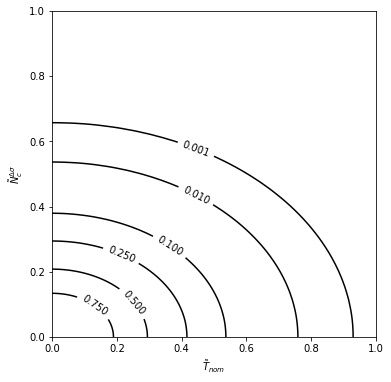

In [20]:
weight_m = np.zeros(2)
weight_lambda = np.array([8, 16]) # weight for Tnom and Nc, respectively

def multiRBF(x,xt,w):
    rbf = np.prod( np.exp(-w*(x-xt)**2), axis=1 )
    return(rbf)

# Generate grid
xx,yy=np.meshgrid(np.linspace(0,1,100),np.linspace(0,1,100))
xy = np.column_stack([xx.flat, yy.flat])
# RBF outputs
zz = multiRBF(xy, weight_m, weight_lambda).reshape(xx.shape)

# Contour plot
plt.figure(figsize=(6,6))
aa=plt.contour(xx, yy, zz, levels=np.array([0.001,0.01, 0.1, 0.25, 0.5, 0.75]), colors='black');
plt.clabel(aa);
plt.xlabel(r'$\tilde{T}_{nom}$');
plt.ylabel(r'$\tilde{N}^{\Delta\sigma}_c$');
plt.subplots_adjust(left=0.15)

## Coordinats for the weighting function

Note that $\text{Tnom}$ is the same in all experiments, thus this coordinate has no effect on the scaling.

In [21]:
NcDs = Nc/(ds**3) # Critical load cycles normalized acc. stress range to the power of 3
Tref = np.max(Tnom) # Reference thickness
NSref = np.max(NcDs) # Reference normalized critical load cycles
Trbf = Tnom/Tref; print('Normalized thickness:', Trbf)
NSrbf = NcDs/NSref; print('Normalized critical load cycles:', np.round(NSrbf,3))

Normalized thickness: [1. 1. 1. 1.]
Normalized critical load cycles: [1.    0.307 0.179 0.184]


## Finding the $\lambda$ parameter(s) of the weighting function by CV

In this section, we will perform cross-validation to find the optimal weighting parameters for the BMA weighting function by holding one experiment out at a time and picking the weighting among the remaining experiments that results in the smallest mean-squared error.


### Cross-validation based on current model realizations

In [22]:
lam_CVv = np.arange(0,30,.2) # lambda values for CV - note that only the NcDs direction matters, as Tnom is the same for all experiments
MSE = np.zeros([len(Tnom), len(lam_CVv)]) # allocate matrix [(T,N) combinations x CV combinations]
for j in range(len(Tnom)):
    Tbma_j = Trbf[j] # thickness for experiment j in [mm]
    NSbma_j = NSrbf[j] # NcDs for experiment j
    Xbma_j = X[j] # x vector for experiment j
    Ybma_j = Y[j] # y vector for experiment j
    # Training set i,j
    ex_ind_tr_j = np.setdiff1d(range(4),j);
    Ttr_j = Trbf[ex_ind_tr_j] # x matrix excluding experiment j
    NStr_j = NSrbf[ex_ind_tr_j] # y matrix excluding experiment j
    for i in range(len(lam_CVv)):
        weigh_ji = multiRBF(np.vstack([Ttr_j, NStr_j]).T, np.array([Tbma_j, NSbma_j]), np.repeat(lam_CVv[i], 2)); 
        weigh_ji = weigh_ji/sum(weigh_ji)
        est_ji = np.zeros([9]) # all four experiments has nine observations
        for t in range(len(weigh_ji)):
            est_ji += F_stats[ ex_ind_tr_j[t] ][np.arange(10,100,10), 0]*weigh_ji[t] # the indices the corr. to the observations in F_stats are 10:10:90
        mse_ji = np.mean( (Ybma_j-est_ji)**2 );
        MSE[j,i] = mse_ji;

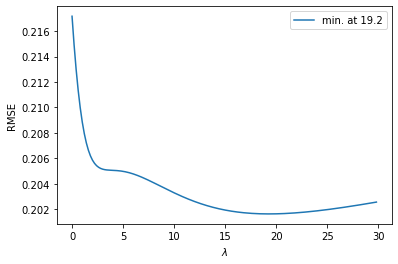

In [23]:
mMSE = np.mean((MSE), axis=0)
plt.figure()
plt.plot(lam_CVv, np.sqrt( mMSE ))
plt.xlabel(r'$\lambda$');
plt.ylabel(r'RMSE');
plt.legend([ 'min. at ' + str( np.round(lam_CVv[np.argmin(mMSE)],1) ) ]);

Note that the cross-validation scheme used above can only be considered a poor-man’s CV, as data-leakage takes place due to the hyper-parameters of the model, which introduces dependency between the experimental models, thus the validation set cannot be considered fully independent of the model. This effect is judged to be of minor importance in this case, as we expect only to use the BMA model within the range of the experimental data. 

### Cross-validation based on model re-sampling

A cross-validation scheme that avoids this short coming simply re-samples the model for each partition of the data, i.e. each training and validation set, and computes the error of each fold based on the corresponding model, see below.

In [24]:
def my_f_mean(x_vec, beta_vec, sigma_vec, gamma_vec):
    f_stats = np.zeros((len(x_vec)))
    for i in range(len(x_vec)):
        f_samp_i = (1 + gamma_vec)*x_vec[i]**(beta_vec) - gamma_vec
        f_stats[i] = np.mean(f_samp_i)

    return f_stats

lam_CVv = np.arange(0,30,.2) # lambda values for CV - note that only the NcDs direction matters, as Tnom is the same for all experiments
MSE = np.zeros([len(Tnom), len(lam_CVv)]) # allocate matrix [(T,N) combinations x CV combinations]
for j in range(len(Tnom)):
    Tbma_j = Trbf[j] # thickness for experiment j in [mm]
    NSbma_j = NSrbf[j] # NcDs for experiment j
    Xbma_j = X[j] # x vector for experiment j
    Ybma_j = Y[j]; # print('\n', Ybma_j, '\n') # y vector for experiment j
    # Training set i,j
    ex_ind_tr_j = np.setdiff1d(range(4),j);
    Ttr_j = Trbf[ex_ind_tr_j] # x matrix excluding experiment j
    NStr_j = NSrbf[ex_ind_tr_j] # y matrix excluding experiment j
    XX = X.copy(); XX.pop(j); xx = np.ndarray.tolist(np.concatenate(XX, axis=0))
    YY = Y.copy(); YY.pop(j); yy = np.ndarray.tolist(np.concatenate(YY, axis=0)) # print('\n', YY, '\n')
    exp_dat_j = {'J': 3, 'N': len(xx), 'x': xx, 'y': yy, 'ind': np.repeat([1,2,3], [9, 9, 9], axis=0)}
    control_j = {}; control_j['adapt_delta'] = 0.99; control_j['max_treedepth'] = 20
    fit_j = sm.sampling(data=exp_dat_j, iter=1000, chains=4, seed=42, control=control_j); 
#     fit_j = sm.sampling(data=exp_dat_j, iter=1000, chains=4, seed=42); 
    hie_samp_j = fit_j.extract(permuted=True)
    for i in range(len(lam_CVv)):
        weigh_ji = multiRBF(np.vstack([Ttr_j, NStr_j]).T, np.array([Tbma_j, NSbma_j]), np.repeat(lam_CVv[i], 2)); 
        weigh_ji = weigh_ji/sum(weigh_ji)
        est_ji = np.zeros([9]) # all four experiments has nine observations
        for t in range(len(weigh_ji)):
            est_ji += my_f_mean(Xbma_j, hie_samp_j['beta'][:,t], hie_samp_j['sigma'][:,t], 
                                hie_samp_j['gamma'][:,t]) * weigh_ji[t]
        mse_ji = np.mean( (Ybma_j-est_ji)**2 );
        MSE[j,i] = mse_ji;

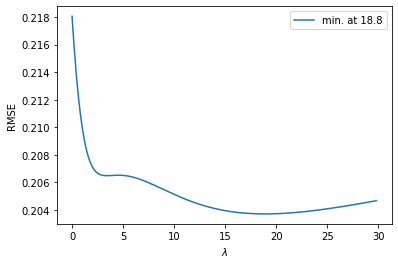

In [25]:
mMSE = np.mean((MSE), axis=0)
plt.figure()
plt.plot(lam_CVv, np.sqrt( mMSE ))
plt.xlabel(r'$\lambda$');
plt.ylabel(r'RMSE');
plt.legend([ 'min. at ' + str( np.round(lam_CVv[np.argmin(mMSE)],1) ) ]);

As expected, a similar optimal weighting is found for this validation scheme.


## Principle assessments of a new fatigue sensitive detail

For this assessment, we will consider a new fatigue sensitive detail with a nominal material thickness of 16 mm and a $N_c/(\Delta\sigma^3) = 1$, thus specifications that are not matched by one of the experiments in the training set.

In [26]:
# Specification of new detail
Tbma = 16 # material thickness in [mm]
NSbma = 1 # normalized critical load cycles from SN-curve or similar

# BMA weighting corr. to specifications of new detail
weights_bma = multiRBF(np.vstack([Tnom/Tref, NcDs/NSref]).T, np.array([Tbma/Tref, NSbma/NSref]), 18.8*np.ones([2]));
weights_bma = weights_bma/sum(weights_bma); print('BMA weights = ', weights_bma)

BMA weights =  [2.50407697e-05 3.76565220e-01 3.08719926e-01 3.14689813e-01]


### BMA samples and sample statistics 

In [27]:
def my_bma_samples(x_vec, beta_mat, sigma_mat, gamma_mat, weights_bma):
    # Samples from the individual models
    F_samp = []
    Y_samp = []
    noise_y = np.random.normal(np.zeros(sigma_mat.shape), sigma_mat)
    for i in range(len(x_ax)):
        # non-shifted and -scaled estimate
        f_samp_i = x_ax[i]**(beta_mat)
        # Scaling and shifting
        for j in range(beta_mat.shape[1]):
            f_samp_i[:,j] = f_samp_i[:,j]*(1 + gamma_mat[:,j]) - gamma_mat[:,j]
        y_samp_i = f_samp_i + noise_y
        F_samp.append(f_samp_i)
        Y_samp.append(y_samp_i)

    # BMA samples
    bma_samp_f = []
    bma_samp_y = []
    for i in range(len(F_samp)):
        bma_samp_f.append( np.dot(F_samp[i], weights_bma) )
        bma_samp_y.append( np.dot(Y_samp[i], weights_bma) )
    bma_samp_f = np.array(bma_samp_f)
    bma_samp_y = np.array(bma_samp_y) 
    
    return( bma_samp_f, bma_samp_y )

def my_bma_stats(bma_mat):
    bma_stats = np.zeros((bma_mat.shape[0],3))
    for i in range(bma_mat.shape[0]):
        bma_samp_i = bma_mat[i,:]
        bma_stats_i_m = np.mean(bma_samp_i)
        bma_stats_i_q = np.quantile(bma_samp_i, [0.025, 0.975])
        bma_stats[i,:] = np.concatenate(([bma_stats_i_m],bma_stats_i_q), axis=0)  
    
    return( bma_stats )
        
# BMA samples
bma_samp_f, bma_samp_y = my_bma_samples(x_ax, beta_samp, sigma_samp, gamma_samp, weights_bma)

# BMA sample statistics
bma_stats_f = my_bma_stats( bma_samp_f )
bma_stats_y = my_bma_stats( bma_samp_y )

# Cropping at 0 and 1
bma_samp_f[bma_samp_f<0] = 0
bma_samp_f[bma_samp_f>1] = 1
bma_stats_f[bma_stats_f<0] = 0
bma_stats_f[bma_stats_f>1] = 1
bma_samp_y[bma_samp_y<0] = 0
bma_samp_y[bma_samp_y>1] = 1
bma_stats_y[bma_stats_y<0] = 0
bma_stats_y[bma_stats_y>1] = 1

### Plot results

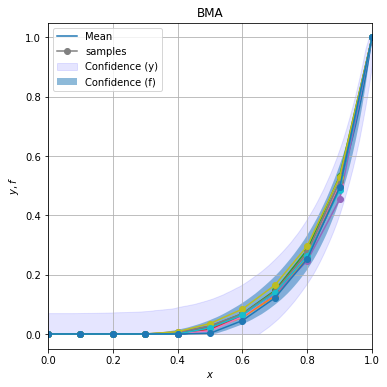

In [28]:
plt.figure(figsize=(6, 6))
plt.plot(x_ax, bma_stats_f[:,0], label ='Mean')
plt.fill_between(x_ax, bma_stats_y[:,1], bma_stats_y[:,2], alpha=0.1, color='blue', label='Confidence (y)')
plt.fill_between(x_ax, bma_stats_f[:,1], bma_stats_f[:,2], alpha=0.5, label='Confidence (f)')
for i in np.arange(160,1160,100):
    plt.plot(x_ax[np.arange(0,110,10)], bma_samp_f[np.arange(0,110,10),i],'o-')
plt.plot([.1,.2], [1.2,1.2],'o-', color = 'grey', label = 'samples')
plt.ylim([-0.05, 1.05])
plt.xlim([0, 1])
plt.xlabel(r'$x$')
plt.ylabel(r'$y,f$')
plt.title('BMA')
plt.legend(loc='upper left')
plt.grid()
plt.subplots_adjust(left=0.15)